<a href="https://colab.research.google.com/github/JiayingTheWarriorForCS/Design.txt/blob/main/Mini_Project_3_Diffusion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project 3
Stencil code for Mini Project 3. **Please make a copy before modifying the code.**

Created by Calvin Luo (calvin_luo@brown.edu), edited by Bumjin Joo (bumjin_joo@brown.edu)

## Imports and Set Up Code

In [ ]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow.keras.layers as tfkl
from tensorflow.keras.utils import Progbar

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import copy

import imageio
import os
import shutil

from IPython.display import Image

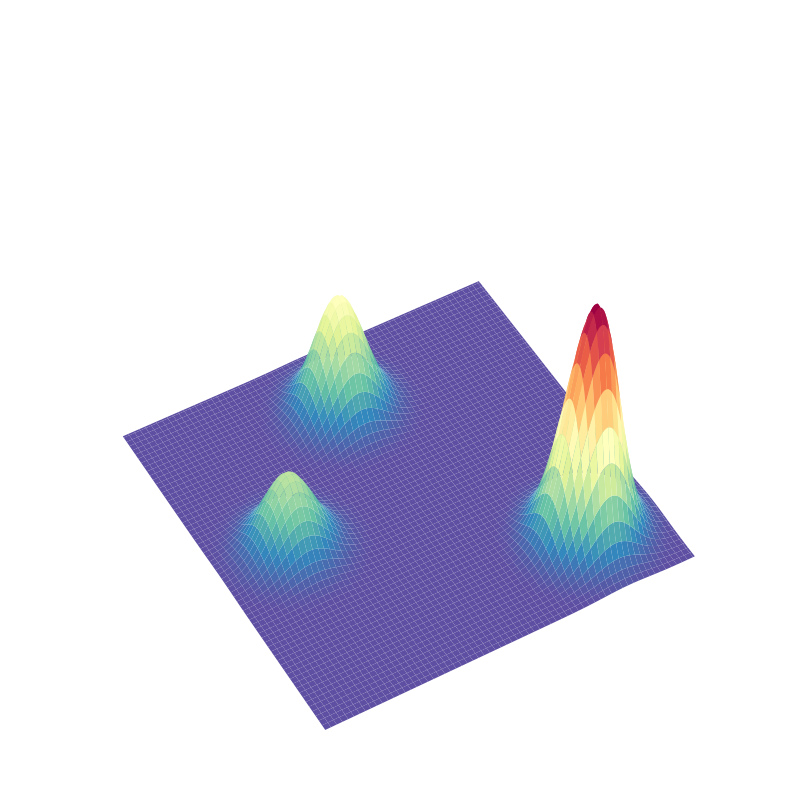

In [ ]:
# Set up Mixture of Gaussians
pi = np.array([0.2, 0.3, 0.6], dtype=np.float32)
mu = np.array([[-5, 0],
               [0, 5],
               [5, -5]], dtype=np.float32)
sigma = np.array([[1, 1],
                  [1, 1],
                  [1, 1]], dtype=np.float32)
gmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=pi),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=mu,
        scale_diag=sigma)
)

# Display Mixture of Gaussians
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1,1,1,projection='3d',aspect='auto')

N = 200
X = np.linspace(-8, 8, N)
Y = np.linspace(-8, 8, N)
X, Y = np.meshgrid(X, Y)
coords = tf.stack([X, Y], axis=-1)
Z = gmm.prob(tf.cast(coords, tf.float32))

ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=0, antialiased=True,
                cmap=cm.Spectral_r, alpha=1.0)

ax1.view_init(50,-120)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

color_tuple = (1.0, 1.0, 1.0, 0.0)

ax1.xaxis.set_pane_color(color_tuple)
ax1.yaxis.set_pane_color(color_tuple)
ax1.zaxis.set_pane_color(color_tuple)
ax1.xaxis.line.set_color(color_tuple)
ax1.yaxis.line.set_color(color_tuple)
ax1.zaxis.line.set_color(color_tuple)

plt.tight_layout()
plt.show()

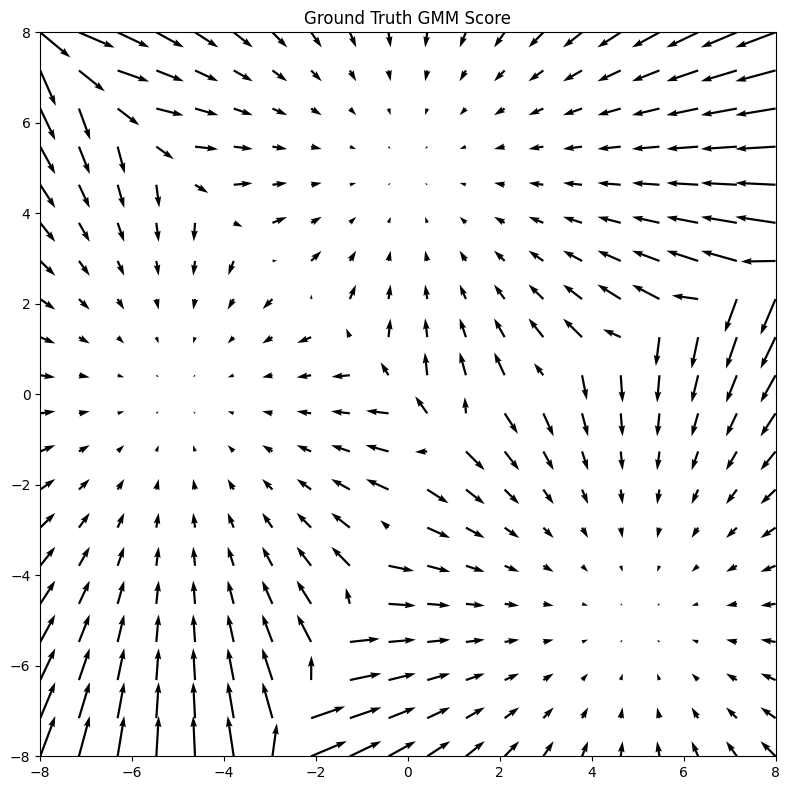

In [ ]:
# Function to access ground truth score
def get_gt_score(inputs):
  with tf.GradientTape() as tape:
    tape.watch(inputs)
    log_prob = tf.reduce_sum(gmm.log_prob(inputs))
  gt_score = tape.gradient(log_prob, inputs)
  return gt_score

# Get grid coordinates, to visualize the flow field
granularity = 20
x_range = np.linspace(-8, 8, granularity, dtype=np.float32)
y_range = np.linspace(-8, 8, granularity, dtype=np.float32)
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_coords = tf.reshape(tf.stack([grid_x, grid_y], axis=-1), (-1, 2))

# Get ground truth flow field
gt_grid_score = get_gt_score(grid_coords)
gt_grid_score = tf.reshape(gt_grid_score, (granularity, granularity, -1))

# Plot the ground truth flow field
plt.figure(figsize=(8,8))
plt.title('Ground Truth GMM Score')
plt.quiver(grid_x, grid_y, gt_grid_score[...,0], gt_grid_score[...,1])
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.tight_layout()
plt.show()

## Step 1: Score Matching
You'll need to edit the `GroundTruthScoreNetwork` and the `DenoisingScoreNetwork` under the Models block!

### Base Models
**Step 1**

There's nothing to edit here for Step 1, but give it a read and run it! It's worth noting that `MLP` and `ScoreNetworkBase` are just base classes for actual networks to inherit from.

**Task 3.1**

You'll need to come back to this block for Step 3 - Langevin Dynamics

Implement the `langevin_dynamics` function in `ScoreNetworkBase`. There's a few variations on sampling techniques that might work here! However, one option you can use can be found in Section 2.2 of [the linked paper](https://arxiv.org/pdf/1907.05600). In this case, the argument `c` represents our step size, while the initial value $\widetilde{\mathbf{x}}_0$ is represented by argument `x`.

In [ ]:
# Step 1: Score Matching - Base Model

class MLP(tf.keras.models.Model):
  def __init__(self, dim_hidden, dim_out, activation='relu', **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dense1 = tfkl.Dense(dim_hidden, activation=activation)
    self.dense2 = tfkl.Dense(2 * dim_hidden, activation=activation)
    self.dense3 = tfkl.Dense(dim_hidden, activation=activation)
    self.dense4 = tfkl.Dense(dim_out)
  def call(self, input, **kwargs):
    x = self.dense4(self.dense3(self.dense2(self.dense1(input))))
    return x

class ScoreNetworkBase(tf.keras.models.Model):
  def __init__(self, hidden_dim, out_dim, dir='score_network', activation='relu', **kwargs):
    super(ScoreNetworkBase, self).__init__(**kwargs)

    # For Plotting
    self.dir = dir
    self.filenames = []
    if os.path.exists(dir):
      shutil.rmtree(dir)
    os.makedirs(dir)

    self.mlp = MLP(hidden_dim, out_dim, activation=activation)

  def call(self, x, **kwargs):
    x = self.mlp(x)
    return x

  def langevin_dynamics(self, x, c=None, num_steps=None):
    # TODO (Step 3): Implement langevin dynamics sampling
    # Suggestion: update default values for c and num_steps that make sense.
    pass

  def train_step(self, x):
    pass

  def test_step(self, x, iter=0):
    # Compute predictions
    y_pred = self(x, training=False)
    y = get_gt_score(x)
    self.plotting(y, y_pred, iter, plot_gt=True)

    self.compiled_loss(y, y_pred, regularization_losses=self.losses)
    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}

  def plotting(self, y, y_pred, iter, plot_gt=True):
    fig, axes = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    fig.tight_layout(pad=2)

    ax = plt.subplot(1, 1, 1)
    ax.quiver(grid_x, grid_y, y_pred[...,0], y_pred[...,1], color='g')
    if plot_gt:
      ax.quiver(grid_x, grid_y, y[...,0], y[...,1], alpha=0.5)
    ax.set_xlim(-8, 8)
    ax.set_ylim(-8, 8)

    ax.set_title(f'{self.dir}, iter {iter}')

    filename = f'{self.dir}/{iter}.png'
    self.filenames.append(filename)

    fig.savefig(filename)
    plt.close()

### Score Matching Models - Task1.2

**Task 1.1**: First, run this block to define `GroundTruthScoreNetwork` and complete Task1.1 below!

**Task 1.2**: After finishing **1.1**, come back to this block and follow the steps below!

You'll need to fill in the train step of the `DenoisingScoreNetwork`.

We can corrupt $x$ to yield $\widetilde{x}$ by adding Gaussian noise of covariance $\sigma^2\mathbf{I}$
* $\widetilde{x} = x + \epsilon, \ \epsilon \sim N (0, \sigma^2\mathbf I)$
* Note that the identity matrix $\mathbf{I}$ is used to indicate a multivariate normal!
* This is the Gaussian kernel, our differentiable corruption

As you work through `train_step`, keep in mind that we're trying to learn a score function represented by `DenoisingScoreNetwork` (called $\psi$ in the linked paper) which acts as a gradient field which, when given a noised input, points to the denoised version of its input!

In [ ]:
# Step 1: Score Matching - Models

class GroundTruthScoreNetwork(ScoreNetworkBase):
  def __init__(self, hidden_dim, out_dim, dir='gt_score_matching', **kwargs):
    super(GroundTruthScoreNetwork, self).__init__(hidden_dim, out_dim, dir=dir, **kwargs)

  def train_step(self, x):
    # Define how we get the ground-truth score signal
    y = get_gt_score(x)

    with tf.GradientTape() as tape:
      y_pred = self(x, training=True)  # Forward pass
      loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}

class DenoisingScoreNetwork(ScoreNetworkBase):
  def __init__(self, hidden_dim, out_dim, dir='denoising_score_matching', sigma=0.5, **kwargs):
    super(DenoisingScoreNetwork, self).__init__(hidden_dim, out_dim, dir=dir, **kwargs)
    # Here, sigma describes the level of noise we add to our input.
    self.sigma = sigma

  def train_step(self, x):
    # TODO (Step 1): Define how we get the ground-truth score signal
    # Hint: first create a noised version of our input.  Then derive y from it.
    y = None

    with tf.GradientTape() as tape:
      # TODO (Step 1): Compute the score matching objective.
      # Hint: What should be the input to our neural network now?
      y_pred = None
      loss = None

    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}

### Score Matching Train Loop - Task1.1

For **Task1.1**, fill in the train step according to the comments below!

Once you finish **Task1.2**, come back to this block and train your `DenoisingScoreNetwork`!

In [ ]:
# Step 1: Score Matching - Train Loop

num_iters = 500
num_samples = 1000
batch_size = 128
lr = 0.005
opt = tf.keras.optimizers.Adam(learning_rate=lr)

# TODO (Step 1): When you are ready, comment out GroundTruthScoreNetwork and try
# your DenoisingScoreNetwork implementation!

model = GroundTruthScoreNetwork(128, 2)
# model = DenoisingScoreNetwork(128, 2)
model.compile(optimizer=opt, loss="mse")

# TODO (Step 1): Generate our dataset as num_samples samples from the gmm
samples = None
dataset = tf.data.Dataset.from_tensor_slices(samples).repeat().batch(batch_size)
dataset_iterator = iter(dataset)

pb = Progbar(num_samples * num_iters, stateful_metrics=['loss'])
for i in range(num_iters):
  # TODO (Step 1): Generate random batch of size batch_size from the dataset
  batch = None

  metrics = model.train_step(batch)
  pb.add(num_samples, values=[(k, v) for k,v in metrics.items()])

  if i > 0 and i % 5 == 0:
    test_metrics = model.test_step(grid_coords, iter=i)

# Generate GIF
with imageio.get_writer(f'{model.dir}.gif', mode='I') as writer:
  for filename in model.filenames:
    image = imageio.v2.imread(filename)
    writer.append_data(image)
Image(f'{model.dir}.gif')

### Score Matching Visualization Functions

The visualization code below is provided to you so you can sanity check your work.

Run this block and make sure things look good!

In [ ]:
#@title Vis Code
# Step 1: Score Matching - Sanity Visualization

final_grid_pred = model(grid_coords, training=False)
plt.figure(figsize=(30,10))

plt.subplot(1, 3, 1)
plt.title("Predicted Score")
plt.quiver(grid_x, grid_y, final_grid_pred[...,0], final_grid_pred[...,1], color='g')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.plot()

plt.subplot(1, 3, 2)
plt.title("Ground Truth Score")
plt.quiver(grid_x, grid_y, gt_grid_score[...,0], gt_grid_score[...,1])
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.plot()

plt.subplot(1, 3, 3)
plt.title("Overlaid Score")
plt.quiver(grid_x, grid_y, final_grid_pred[...,0], final_grid_pred[...,1], color='g')
plt.quiver(grid_x, grid_y, gt_grid_score[...,0], gt_grid_score[...,1])
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.plot()

## Step 2: Noise-Conditioned Score Matching

### Noise Conditioned Score Network (NCSN)
**Task 2.1**

First, take a look at `PosEmbedding` (it should look pretty familiar)! Then fill out the `TimeEmbedding` layer which, when given an integer time index, returns the described outputs.

Next, fill in the `NCSN`! You'll have to change or add to
* `__init__`
* `call`
* `train_step`

When doing `train_step`, pick batch size number of random time steps between 0 and `noise_levels`. Then, for each of these time steps, gather the respective variance from the `variance_noise_schedule`, which holds a variance for each time step! Once you do that, then do the same noising operation on `x` as you did in step 1, but with a different standard deviation of noise for each sample.

**Task 3.1**

Fill in `time_cond_langevin`. This should be pretty similar to the `langevin_dynamics` method you just filled out, but adjusted to address the different call function for the `NCSN`!

**Task 3.2**

Check out the definition of NCSN Inference via Annealed Langevin Dynamics in the paper! Notice how one of the steps looks pretty similar to the `time_cond_langevin` you had just coded out.

Take a second to consider what the correct time index is to get the appropriate variance from the variance schedule!

In [ ]:
# Step 2: Noise-Conditioned Score Matching - Model

class PosEmbedding(tf.keras.layers.Layer):
  def __init__(self, dim):
    super(PosEmbedding, self).__init__()
    self.dim = dim

  def call(self, time):
    dim = self.dim/2

    positions = tf.cast(tf.expand_dims(time, -1), tf.float32)
    dims = tf.expand_dims(tf.range(dim), 0)/dim

    angle_rates = 1 / (10000**dims)
    angle_rads = positions * angle_rates

    pos_encoding = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

class TimeEmbedding(tf.keras.models.Model):
  def __init__(self, hidden_dim, out_dim, **kwargs):
    super(TimeEmbedding, self).__init__(**kwargs)
    # TODO (Step 2): Instantiate a positional embedding model, with a dim of your choice.
    self.pos_embed = None
    self.dense = tfkl.Dense(out_dim)

  def call(self, input, **kwargs):
    # TODO (Step 2): Compute and return the positional embedding for the time index
    # Suggestion: input should be an integer time index
    # Suggestion: apply a dense layer to the output of the positional embedding
    pass

class NCSN(ScoreNetworkBase):
  def __init__(self, hidden_dim, out_dim, dir='ncsn', noise_levels=10, **kwargs):
    super(NCSN, self).__init__(hidden_dim, out_dim, dir=dir, **kwargs)

    # TODO (Step 2): Instantiate a time embedding model
    self.emb_time = None

    self.noise_levels = noise_levels
    self.variance_schedule = self.linear_schedule(noise_levels)

  def linear_schedule(self, timesteps):
    lin_start = 0.5 # pre-chosen
    lin_end = 20 # pre-chosen
    return tf.cast(tf.linspace(lin_start, lin_end, timesteps), tf.float32)

  def call(self, x, time_idxs=None, **kwargs):
    # TODO (Step 2): Condition the score prediction on time
    # Hint: Try concatenating the time embedding with the input
    pass

  def train_step(self, x):
    # TODO (Step 2): Define how we get the ground-truth score signal
    # Hint: How does relate to Step 1?
    y = None

    with tf.GradientTape() as tape:
      # TODO (Step 2): Compute the score matching objective
      y_pred = None
      loss = None

    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}

  def time_cond_langevin_dynamics(self, x, t_idx=None, c=None, num_steps=None):
    # TODO (Step 3): Implement time-conditioned langevin dynamics sampling
    pass

  def annealed_langevin_dynamics(self, x, c=None, num_steps_per_lvl=None, return_intermediate=False):
    # TODO (Step 3): Implement annealed langevin dynamics sampling over self.noise_levels
    # TODO (Step 3): Add a flag to return all intermediate sampling steps, to visualize how samples are generated over noise levels.
    pass

### NCSN Train Step
**Task 2.1**
Fill in the missing parts below

Notice here that `noise_levels` should be an integer representing the max level of noise (time steps). Gathering the sample and batch should look very familiar!

In [ ]:
# Step 2: Noise-Conditioned Score Matching - Train Loop

num_iters = 500
num_samples = 1000
batch_size = 128
lr = 0.005
opt = tf.keras.optimizers.Adam(learning_rate=lr)

# TODO (Step 2): Choose an appropriate number of noise levels
noise_levels = None

model = NCSN(128, 2, noise_levels=noise_levels)
model.compile(optimizer=opt, loss="mse")

# TODO (Step 2): Generate dataset as num_samples samples from the gmm
samples = None
dataset = tf.data.Dataset.from_tensor_slices(samples).repeat().batch(batch_size)
dataset_iterator = iter(dataset)

pb = Progbar(num_samples * num_iters, stateful_metrics=['loss'])
for i in range(num_iters):
  # TODO (Step 2): Generate random batch of size batch_size from the dataset
  batch = None

  metrics = model.train_step(batch)
  pb.add(num_samples, values=[(k, v) for k,v in metrics.items()])

### NCSN Visualization
**Task 2.1** Run the visualization block below and check that things look good!

In [ ]:
#@title NCSN Vis
# Step 2: Score Matching - Sanity Visualization Over Noise Levels
fnames = []
for i in range(model.noise_levels)[::-1]:
  final_grid_pred = model(grid_coords, tf.ones(grid_coords.shape[0]) * i)

  fig, axes = plt.subplots(1, 1)
  fig.set_size_inches(24, 8)
  fig.tight_layout(pad=2)

  ax = plt.subplot(1, 3, 1)
  ax.set_title(f'Predicted Score, Noise Level {i}')
  ax.quiver(grid_x, grid_y, final_grid_pred[...,0], final_grid_pred[...,1], color='g')
  ax.set_xlim(-8, 8)
  ax.set_ylim(-8, 8)

  ax = plt.subplot(1, 3, 2)
  ax.set_title(f'Ground Truth Score')
  ax.quiver(grid_x, grid_y, gt_grid_score[...,0], gt_grid_score[...,1])
  ax.set_xlim(-8, 8)
  ax.set_ylim(-8, 8)

  ax = plt.subplot(1, 3, 3)
  ax.set_title(f'Overlaid Score, Noise Level {i}')
  ax.quiver(grid_x, grid_y, final_grid_pred[...,0], final_grid_pred[...,1], color='g')
  ax.quiver(grid_x, grid_y, gt_grid_score[...,0], gt_grid_score[...,1])
  ax.set_xlim(-8, 8)
  ax.set_ylim(-8, 8)

  fname = f'{model.dir}/final_{i}.png'
  fnames.append(fname)

  fig.savefig(fname)
  plt.close()

with imageio.get_writer(f'{model.dir}.gif', mode='I') as writer:
  for fname in fnames:
    image = imageio.v2.imread(fname)
    writer.append_data(image)
Image(f'{model.dir}.gif')

## Step 3: Langevin Dynamics

**Task 3.1**

First, head back up to the Base Models section and fill in the `langevin_dynamics` function! More details are up there.
Make sure to rerun the `BaseModel` block AND the `DenoisingScoreNetwork` block.

Next, fill in `time_cond_langevin_dynamics` under `NCSN`, rerun that block, and run the next 2 blocks below with the appropriate lines uncommented out.

**Task 3.2** Annealed Langevin Dynamics

Go back to `NCSN` and fill in `annealed_lagenvin_dynamics`



In [ ]:
num_iters = 500
num_samples = 1000
batch_size = 128
lr = 0.005
opt = tf.keras.optimizers.Adam(learning_rate=lr)

model = DenoisingScoreNetwork(128, 2)
# model = NCSN(128, 2, noise_levels=noise_levels) #uncomment when ready to test your time condition or annealed langevin dynamics!

model.compile(optimizer=opt, loss="mse")

# TODO (Step 3): Generate our dataset as num_samples samples from the gmm
samples = None
dataset = tf.data.Dataset.from_tensor_slices(samples).repeat().batch(batch_size)
dataset_iterator = iter(dataset)

pb = Progbar(num_samples * num_iters, stateful_metrics=['loss'])
for i in range(num_iters):
  # TODO (Step 3): Generate random batch of size batch_size from the dataset
  batch = None

  metrics = model.train_step(batch)
  pb.add(num_samples, values=[(k, v) for k,v in metrics.items()])

### Visualizing Samples from Langevin Dynamics

**Task 3.1 and 3.2**

Try out some different values and see how the Langevin Dynamics-generated points look compared to Ground Truth Samples!

In [ ]:
# Step 3: Langevin Dynamics Sampling - Visualize Samples
num_samples = None
c = None
num_steps_per_lvl = None
time_steps = np.random.choice(50, num_samples)

unif_rand_sample = tf.random.uniform((num_samples, 2), minval=-8, maxval=8)
pred_samples = model.langevin_dynamics(unif_rand_sample, c, num_steps_per_lvl)
# pred_samples = model.time_cond_langevin_dynamics(unif_rand_sample, t_idx = time_steps, c=c, num_steps=num_steps_per_lvl)
# pred_samples = model.annealed_langevin_dynamics(unif_rand_sample, c, num_steps_per_lvl)
gt_samples = gmm.sample(num_samples)

plt.figure(figsize=(8,8))
plt.title("Generated Samples vs. Ground-Truth Samples")
plt.scatter(pred_samples[:, 0], pred_samples[:, 1], color='g')
plt.scatter(gt_samples[:, 0], gt_samples[:, 1], color='r')
plt.legend(['Generated Samples', 'Ground-Truth Samples'])
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.plot()

### Visualizing Annealed Langevin Dynamics Over Time

**Task 3.2**

Fill in some values and see how the Langevin Dynamics-generated points look over the different noise levels!

In [ ]:
# Step 3: Langevin Dynamics Sampling - Visualize Sampling Over Noise Levels
num_samples = None
c = None
num_steps_per_lvl = None

unif_rand_sample = tf.random.uniform((num_samples, 2), minval=-8, maxval=8)
pred_samples = model.annealed_langevin_dynamics(unif_rand_sample, c, num_steps_per_lvl, return_intermediate=True)

sample_fnames = []

for i in range(len(pred_samples)):

  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(1,1,1,projection='3d')

  ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=0, antialiased=True,
                  cmap=cm.Spectral_r, alpha=0.5,label='_nolegend_')

  ax.view_init(30,-120)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_zticks([])

  color_tuple = (1.0, 1.0, 1.0, 0.0)

  ax.xaxis.set_pane_color(color_tuple)
  ax.yaxis.set_pane_color(color_tuple)
  ax.zaxis.set_pane_color(color_tuple)
  ax.xaxis.line.set_color(color_tuple)
  ax.yaxis.line.set_color(color_tuple)
  ax.zaxis.line.set_color(color_tuple)

  mask = (pred_samples[i][:,0] >= -8) & (pred_samples[i][:,0] <= 8) & (pred_samples[i][:,1] >= -8) & (pred_samples[i][:,1] <= 8)
  x_masked = np.ma.masked_array(pred_samples[i][:,0], ~mask)
  y_masked = np.ma.masked_array(pred_samples[i][:,1], ~mask)
  z_masked = np.ma.masked_array(gmm.prob(pred_samples[i]), ~mask)

  ax.scatter(x_masked, y_masked, z_masked + 0.001, color='g', alpha=1.0)

  ax.set_xlim(-8, 8)
  ax.set_ylim(-8, 8)

  plt.legend(['Generated Samples'])

  plt.tight_layout()

  fname = f'{model.dir}/sample_{i}.png'
  sample_fnames.append(fname)

  fig.savefig(fname)
  plt.close()

with imageio.get_writer(f'{model.dir}.gif', mode='I') as writer:
  for fname in sample_fnames:
    image = imageio.v2.imread(fname)
    writer.append_data(image)
Image(f'{model.dir}.gif')